# Outlier detection workshop

We are going to investigate some methods and models to detect outliers. We'll also discuss the usecases of this methods.

Agenda: 

1. Example of biasing models quality by outliers. Robust models.
2. Mahalanobis rule
3. Local Outlier Factor
3. Isolation Forest
1. One-Class SVM

Dataset for workshop: http://odds.cs.stonybrook.edu/breast-cancer-wisconsin-original-dataset/

# Google Drive connection

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
data_path = '/content/drive/My Drive/Data Science Basic/08 Clustering and outlier detection/OD/Workshop/data'

# Code

In [ ]:
def report(y_data, predictions):
  predictions = predictions.copy()

  predictions[predictions == 1] = 0
  predictions[predictions == -1] = 1


  print(classification_report(y_data, predictions))

# Necessary imports

In [ ]:
import numpy as np
import pandas as pd

import itertools

from sklearn.datasets import load_wine

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from tqdm.notebook import tqdm as tqdm

from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import  train_test_split
from sklearn.metrics import r2_score

import seaborn as sns
import matplotlib.pyplot as plt

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
np.random.seed(10000)

# Models bias by outliers

Some models are less robust to outliers than others. We can show that removing outliers from train data can improve metrics without changing other params.

In [ ]:
# Some code to genetare data

mean_x = 5
var_x = 4

var_y = 3

slope = 1

count_samples = 100

x = var_x * np.random.randn(count_samples) + mean_x
y = slope * x + var_y * np.random.randn(count_samples)

In [ ]:
# Some code to genetare outliers

count_outliers = 5

x_bias = 5
y_bias = 20

outliers_x = var_x * np.random.randn(count_outliers) + x_bias
outliers_y = slope * outliers_x + var_y * np.random.randn(count_outliers) + y_bias

outliers_mask = np.zeros(count_samples + count_outliers)
outliers_mask[count_samples:] = 1

data_x, data_y = np.hstack([x, outliers_x]), np.hstack([y, outliers_y])

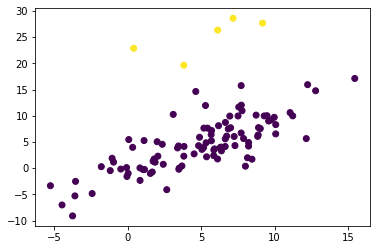

In [ ]:
plt.scatter(data_x, data_y , c=outliers_mask)

In [ ]:
x_train, x_test, y_train, y_test, train_outliers, test_outliers = train_test_split(data_x, data_y, outliers_mask, train_size=0.8)

In [ ]:
logreg = LinearRegression()

logreg.fit(x_train.reshape(-1,1), y_train)

y_pred = logreg.predict(x_test.reshape(-1,1))

r2_score(y_test, y_pred)

0.39405184193700327

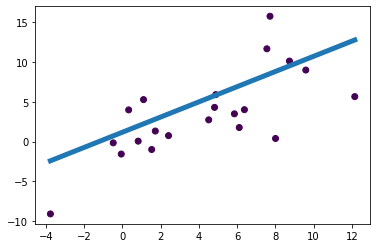

In [ ]:
plt.scatter(x_test, y_test , c=test_outliers)

plt.plot(np.sort(x_test), y_pred[np.argsort(x_test)], linewidth=5)

In [ ]:
logreg = LinearRegression()

x_train_clean = x_train[train_outliers == 0]
y_train_clean = y_train[train_outliers == 0]

logreg.fit(x_train_clean.reshape(-1,1), y_train_clean)

y_pred = logreg.predict(x_test.reshape(-1,1))

r2_score(y_test, y_pred)

0.4941204784268174

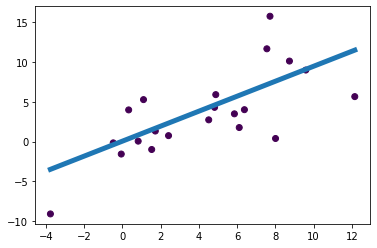

In [ ]:
plt.scatter(x_test, y_test , c=test_outliers)

plt.plot(np.sort(x_test), y_pred[np.argsort(x_test)], linewidth=5)

# Data overview

In [ ]:
data = pd.read_csv(data_path + '/breastw.csv', index_col='Unnamed: 0', engine='python')

In [ ]:
data.head().T

,0,1,2,3,4
0,5,5,3,6,4
1,1,4,1,8,1
2,1,4,1,8,1
3,1,5,1,1,3
4,2,7,2,3,2
5,1,10,2,4,1
6,3,3,3,3,3
7,1,2,1,7,1
8,1,1,1,1,1
target,0,0,0,0,0


In [ ]:
target = 'target'

features = list(data.columns)
features.remove(target)
features

['0', '1', '2', '3', '4', '5', '6', '7', '8']

In [ ]:
x_data = data[features]
y_data = data[target]


In [ ]:
y_data.value_counts()

0    444
1    239
Name: target, dtype: int64

In [ ]:
data[target] = data[target].astype(str)

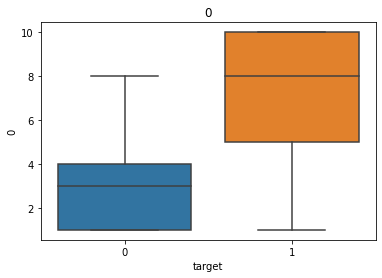

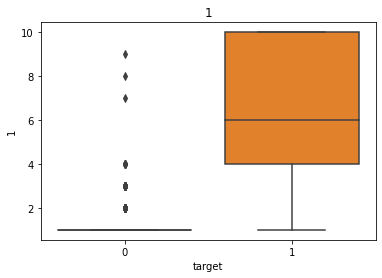

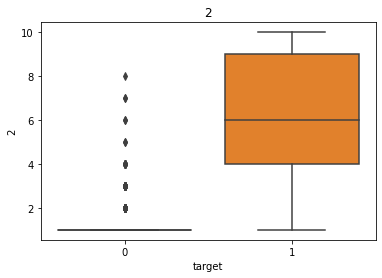

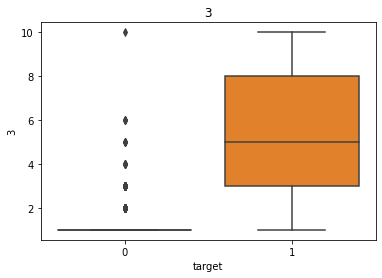

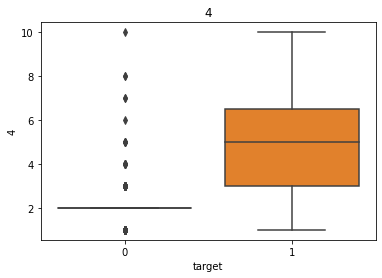

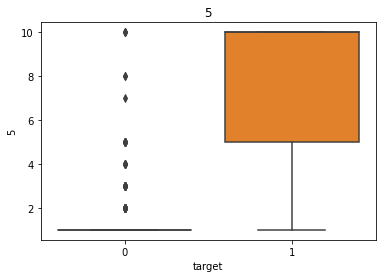

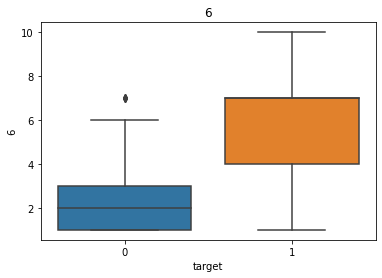

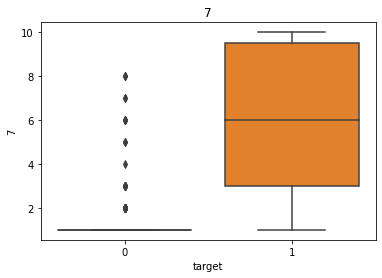

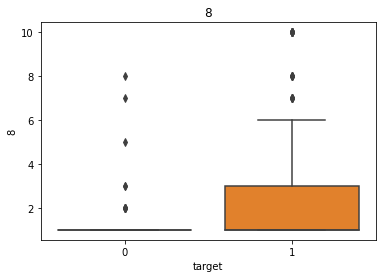

In [ ]:
for feature in features:    
    plt.figure()
    sns.boxplot(y = feature, x=target, data=data, )
    plt.title(feature)

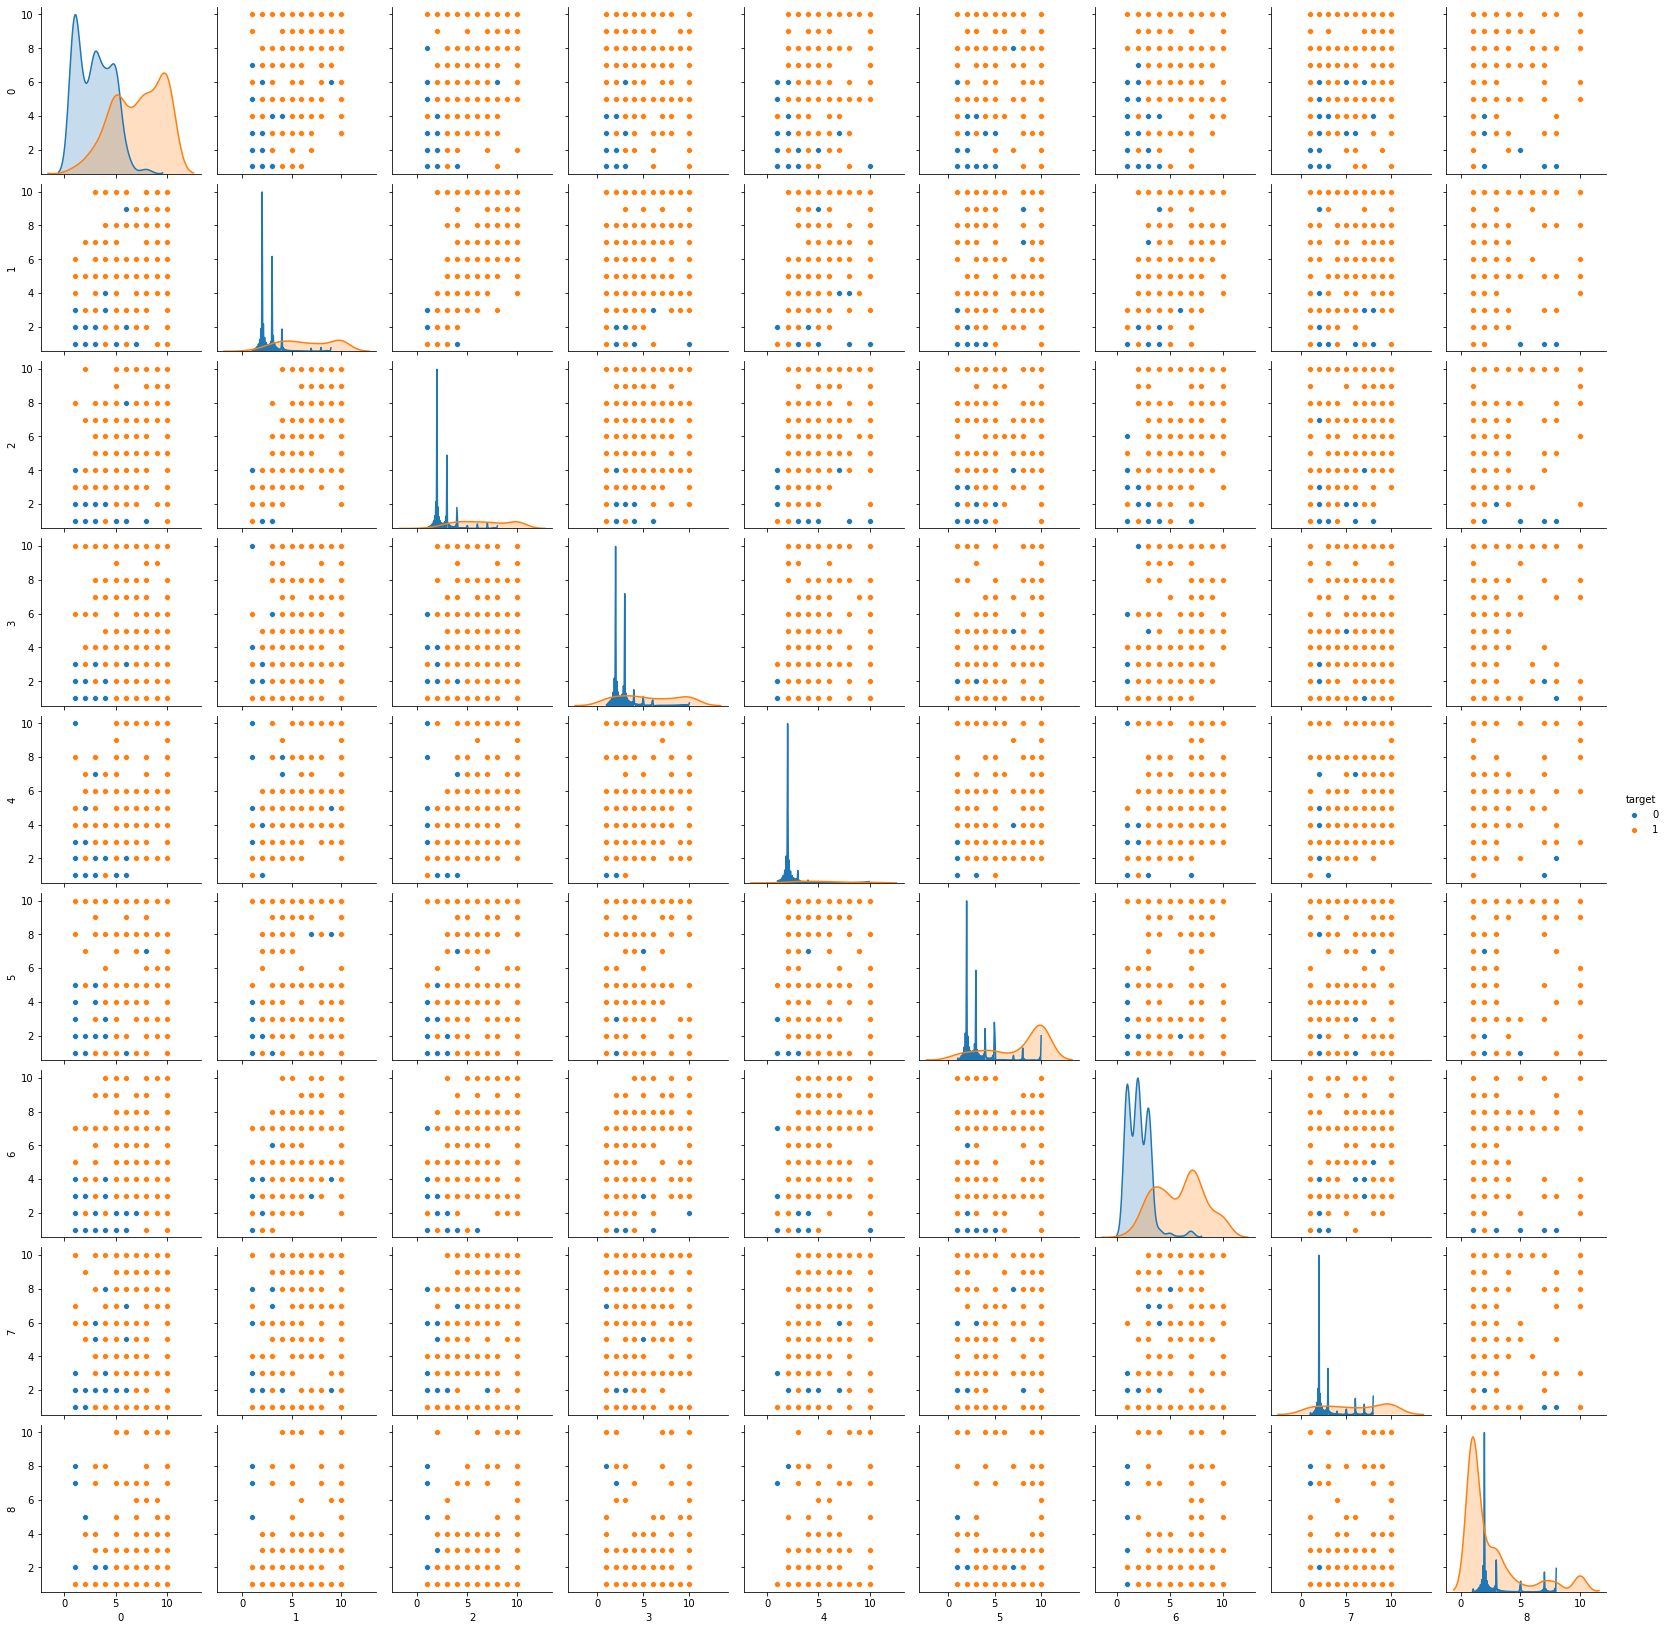

In [ ]:
sns.pairplot(data[features + [target]], hue=target)

## Data vizualiztion

Reduce data dimesionality with PCA to vizualize output

In [ ]:
# Your code

# Mahalanobis rule

How we can measure the distance between points? One the most common metrics is euclidean distance:

> $d(x, y) = \sqrt{((x_1 - y_1)^2 + ... + (x_n - y_n)^2)}$

This metric doesn't depend on distribution of samples and equally weight all dimesions. To solve this problem we can intriduce weighted distance metric - Mahalanobis distance:
> $D_M(x,y) ^2 = (x-y)^T * C^{-1} * (x - y)$, where x, y - vectors of to measure distance and $ C^{-1}$ - inverse covariance matrix of data.

This metric rotates coordinate system to remove correlations between axes and scales to make dispersion by each axis equal to 1.

Aterward we can measure distance between samples and center of data and provide chi-square test to detect outliers:
> $\chi_n ^2 (x) = D_M(x, m) = (x - m)^T * C^{-1} * (x - m)$  where m - mean vector of data, n - data dimensionality. <br>
$p\_value = 1 - \chi_{1-\alpha} ^2 (n)$





![](https://www.machinelearningplus.com/wp-content/uploads/2019/04/Mahalanobis_Distance_Usecase.jpg)


In [ ]:
from scipy.spatial.distance import pdist, mahalanobis, squareform
from scipy.stats import chi2

## Compute Mahalanobis distance between random pair of rows in dataset using numpy

In [ ]:
# Your code 



## Check yourself with scipy package
We can use scipy.spatial.distance.mahalanobis. Compare with output above. Also we can compute the full distance matrix by 'pdist' and 'squareform' functions.

In [ ]:
# Your code 


## Compute mean vector, distance from sample to mean and p_value.  


In [ ]:
# Your code 


## Visualize output predictions and get metrics

In [ ]:
# Predictions by p_value

In [ ]:
# Plot

In [ ]:
# Metrics

## Conclusions

1) Optimal case to use this method - multivariate gaussian distribution of data <br>
2) Straightforward usage - no hyperparams to tune <br>
3) Doesn't work in clusters case - each cluster can have its own convariance and mean. 

# Local Outlier Factor



Density based distance:

> r(x,y) - metric of distance between points. <br>
$k-distance = r(x,x_k)$ - distance between x and k nearest neighbor x_k <br>
$reachability-distance(x,y) = max\{k-distance(y), r(x,y)\}$ <br>
$lrd_k(x) = 1/(\frac{\sum_{y \in N_k(x)} reachability-distance(x,y)}{|N_k(x)|})$ - local reachability density, where $N_k(x)$ - set of k nearest neighbors. <br>
 
$LOF_k(x) = \frac{\sum_{y \in N_k(x)}(lrd(y))}{|N_k(x)|} / lrd(x)$ - fraction of mean local reachability densities of neighbros and sample's local reachability density.

If LOF_k ~ 1 => point density comparable to neighbors' => point is not outlier. <br>
If LOF >> 1 => point density strongly less than neighbors' => point is outlier

In [ ]:
from sklearn.neighbors import LocalOutlierFactor

## Try sklearn implementation sklearn.neighbors.LocalOutlierFactor



In [ ]:
# Your code

## Test other representations of data
We can pass a distance matrix computed in Mahalanabis distance section or data with reduced dimesionality

In [ ]:
# Plot



In [ ]:
# Metrics

## Conclusions

# Isolation Forest



Tree-based algorithm for detecting rare points. <br> Intuition: if in random decision tree point often cuts off earlier than others - it can be considered as outlier.

Algorithm of tree training:
> 1) Get random feature $p$ and split value $v$. <br>
2) Split data by feature-value pair on two subsets: $S_1$ all points with feature value less than $v$ and $S_2$ greater than $v$. <br>
3) Repeat (1)-(2) until subsets have more than 1 point.

After training a forest we intriduce measure of sample anomality as mean length of paths in all trees. <br>
If this score is less than some threshold => it is outlier
The threshold can be set manually or computed via formula in https://cs.nju.edu.cn/zhouzh/zhouzh.files/publication/icdm08b.pdf?q=isolation-forest - out of scope of this lecture.



![](https://miro.medium.com/max/700/1*xCZtQspQaHSmwniINWTeLQ.png)

In [ ]:
from sklearn.ensemble import IsolationForest

## Try sklearn.ensemble.IsolationForest

In [ ]:
# Your code

## Visualize and get metrics

In [ ]:
# Plots



In [ ]:
# Metrics

# One-Class SVM

---



SVM-based model. Intuition - if we can make a decision boundary of minimal space, samples out of this boundary are classified as outliers.
<br> 
Theory similar to SVM classification, the only difference is that we don't have negative class.


![Замещающий текст](https://scikit-learn.org/stable/_images/sphx_glr_plot_oneclass_001.png)

In [ ]:
from sklearn.svm import OneClassSVM

## Try sklearn.svm.OneClassSVM

In [ ]:
# Your code

## Test different representations of data
We can pass a distance matrix computed in Mahalanabis distance section or data with reduced dimesionality

In [ ]:
# Make predictions

In [ ]:
# Plot

In [ ]:
# Metrics

# Conclusions